# Web Traffic Forecasting - Part 2: Traditional Machine Learning #

## Methodology ##
Supervised machine learning models are often the go-to methods for many prediction tasks, and their versatility also gives them the ability to handle time series forecasting. However, different from a standard supervised machine learning task, which is built upon the assumption that each observation is independent, time series data can suffer from the issue of lacking independent variables. For example, given one time series of one website, within which every single entry is the number of visits to that page on a certain day, these entries especially those that are close or next to each other (e.g. visit on day 1 and visit on day 2) can be highly correlated -- in other words, there are often no independent variables in time series data. Also, each entry can be a potential target since the number of visits is exactly what we hope to predict.

To solve this problem and thus fit the time series forecasting into the framework of traditional supervised learning, we need to generate independent variables (features). To do so, we can extract information from the time series such as seasonality, average traffic of the last 7 days, etc. as independent variables to help predict visits (traffic on a chosen day).

While we can manually extract the above features by analyzing and preprocessing the data, luckily, there is a package called [tsfresh](https://tsfresh.com/), which helps in extracting features from time series data such as mean, max, min, median, 0.4 quantile, 0.7 quantile, linear trend attribute intercept, etc. Once we extract these features, the problem is converted to a machine learning problem instead of a time series one, and we can apply the traditional ML models we are familiar with.

Note: using this method, we can predict web traffic on a certain day for websites in bulk (in our case, 1000 websites) since after conversion, every row is an independent observation with extracted features and one target traffic.



In [2]:
# import packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

import warnings
warnings.filterwarnings("ignore")

# time series feature extraction
!pip install tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

# modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 30.4 MB/s 
     |████████████████████████████████| 136 kB 45.1 MB/s 
     |████████████████████████████████| 9.9 MB 47.9 MB/s 
     |████████████████████████████████| 1.3 MB 52.4 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.11.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompa

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 7.1 MB/s 


In [3]:
def train_evaluate(X_filtered_train, y_train, X_filtered_test, y_test,model):
    """
    Train the given model based on the given train dataset (features and target),
    and test dataset (features and target). Evaluate the model trained using 
    train RMSE, test RMSE, train R2, and test R2.
    
    Args:
      X_filtered_train: a dataframe of features to train the model
      y_train: a series of target to train the model
      X_filtered_test: a dataframe of features to test the model
      y_test: a series of target to test the model
      model: model to be trained and evaluated

    Returns:
      train_error: train root mean squared error
      test_error: test root mean squared error
      train_r2: train R-squared
      test_r2: test R-squared
  
    """    
    # train the model
    model.fit(X_filtered_train, y_train)
    
    # get train and test RMSE
    train_error = np.sqrt(mean_squared_error(y_train, model.predict(X_filtered_train)))
    test_error = np.sqrt(mean_squared_error(y_test, model.predict(X_filtered_test)))
    
    # get train and test R2
    train_r2 = r2_score(y_train, model.predict(X_filtered_train))
    test_r2 = r2_score(y_test, model.predict(X_filtered_test))

    # return evaluation results
    return train_error, test_error, train_r2, test_r2

In [4]:
def sliding_window(elements, window_size):
    """
    Create sliding/rolling windows based on the given size.

    Example:
      elements = [0,1,2,3,4,5]
      window_size = 4
      feature indeces: [[0,1,2,3],[1,2,3,4]], target index: [4,5]

    Args:
      elements: a list of elements to generate sliding window from
      window_size: number of elements in the sliding window

    Return:
      X_idx: a nested list of indeces  by sliding window
      y_idx: a list of target indeces by sliding window
    """

    # initiate results holders
    X_idx = []
    y_idx = []

    # generate sliding window
    for i in range(len(elements) - window_size):
        X_idx += [elements[i:i+window_size]]
        y_idx += [elements[i:i+window_size+1][-1]]
    return X_idx, y_idx

In [5]:
def predict_evaluate(X, y, model):
    """
    Predict target based on the given features and model trained
    Evaluate the model performance 

    Args:
      X: a dataframe of features
      y: a series of true targets/labels
      model: model trained, used to generate predictions

    Return:
      pred: a series of predicted labels
      error: root mean squared error of actual labels and predicted labels
      r2: R-squared of actual labels and predicted labels
        
    """    
    pred = model.predict(X)
    error = np.sqrt(mean_squared_error(y, model.predict(X)))
    r2 = r2_score(y, model.predict(X))

    
    return pred, error, r2

In [6]:
# Please change the path of this data file into the correct path of your own google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

%cd /content/drive/My Drive/Course/F22/'94867 DABP'/'94867 DABP Project'/

Mounted at /content/drive
/content/drive/My Drive/Course/F22/94867 DABP/94867 DABP Project


## 1. Data Preprocessing & Feature Engineering##

In [9]:
# read in cleaned dataset
df_sorted_std = pd.read_csv('data/train_data1000.csv')

# train test split using the row index
# since each row is an independent page, we can doing random train test split
train_idx, test_idx = train_test_split(df_sorted_std.index, test_size=0.2, random_state=0)

# impute missing values for train and test set seperately to prevent data leakage
train_imputed = df_sorted_std.iloc[train_idx].interpolate(limit_direction='both')
test_imputed = df_sorted_std.iloc[test_idx].interpolate(limit_direction='both')

In [10]:
# format train dataset
train_imputed_ts = (train_imputed.reset_index()
                              .rename(columns={'index':'page'})
                              .drop(columns='Page'))

# use the first 73 days starting from no missing values 
# (not including the imputed ones) in the train dataset to train the model
X_train =  train_imputed_ts.iloc[:,np.r_[0,536:536+72]].rename(columns={'index':'page'})
y_train = train_imputed.iloc[:,536+72].sort_index()



In [11]:
# format the test dataset
test_imputed_ts = (test_imputed.reset_index()
                              .rename(columns={'index':'page'})
                              .drop(columns='Page'))

# use the first 73 days starting from no missing values 
# (not including the imputed ones) in the test dataset to train the model
X_test = test_imputed_ts.iloc[:,np.r_[0,536:536+72]].rename(columns={'index':'page'})
y_test = test_imputed.iloc[:,536+72].sort_index()

In [12]:
# melt training feature dataframe to prepare for tsfresh feature extraction
ts_X_train = (pd.melt(X_train, 
                      id_vars='page', 
                      value_vars=list(X_train.columns), 
                      var_name='time', 
                      value_name='view')
                .sort_values(by=['page','time'])
                .reset_index(drop=True))

In [13]:
# melt test feature dataframe to prepare for tsfresh feature extraction
ts_X_test = (pd.melt(X_test, 
                     id_vars='page', 
                     value_vars=list(X_test.columns), 
                     var_name='time', 
                     value_name='view')
               .sort_values(by=['page','time'])
               .reset_index(drop=True))

In [14]:
# extract time-series related features from features in the training dataset
X_feature_train = extract_features(ts_X_train, column_id='page',column_sort="time")

Feature Extraction: 100%|██████████| 800/800 [01:21<00:00,  9.81it/s]


In [15]:
# extract time-series related features from features in the test dataset
X_feature_test = extract_features(ts_X_test, column_id='page',column_sort="time")

Feature Extraction: 100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


In [16]:
# impute extracted features in case there exist null values
impute(X_feature_train)
impute(X_feature_test)

# filter and use only highly relevant extracted features
filtered_features = select_features(X_feature_train,y_train)

# get filtered features for training and testing
X_filtered_train, X_filtered_test = X_feature_train[filtered_features.columns], X_feature_test[filtered_features.columns]

In [ ]:
# take a look at the extracted raw features
# there are 780 features in total
X_feature_train.head()

,view__variance_larger_than_standard_deviation,view__has_duplicate_max,view__has_duplicate_min,view__has_duplicate,view__sum_values,view__abs_energy,view__mean_abs_change,view__mean_change,view__mean_second_derivative_central,view__median,...,view__permutation_entropy__dimension_6__tau_1,view__permutation_entropy__dimension_7__tau_1,view__query_similarity_count__query_None__threshold_0.0,"view__matrix_profile__feature_""min""__threshold_0.98","view__matrix_profile__feature_""max""__threshold_0.98","view__matrix_profile__feature_""mean""__threshold_0.98","view__matrix_profile__feature_""median""__threshold_0.98","view__matrix_profile__feature_""25""__threshold_0.98","view__matrix_profile__feature_""75""__threshold_0.98",view__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,82987.0,9.925559e+07,147.000000,2.098592,0.957143,1099.0,...,3.969282,4.126641,0.0,0.872402,3.077871,1.779326,1.685408,1.308852,2.139086,1592.000000
2,1.0,0.0,0.0,0.0,378315.0,2.000957e+09,263.774648,34.422535,11.042857,5226.0,...,4.121929,4.168650,0.0,0.872402,3.077871,1.779326,1.685408,1.308852,2.139086,6225.000000
3,1.0,0.0,0.0,1.0,379350.0,2.009468e+09,265.112676,3.253521,1.657143,5212.0,...,4.101238,4.168650,0.0,0.969203,3.563853,2.250431,2.335351,1.986966,2.554140,6010.000000
4,1.0,0.0,0.0,1.0,417248.0,2.439804e+09,292.577465,-5.788732,-1.578571,5696.5,...,4.031355,4.189655,0.0,0.872402,3.077871,1.779326,1.685408,1.308852,2.139086,7001.142857
6,1.0,0.0,0.0,1.0,404294.0,2.305547e+09,367.436620,29.774648,4.792857,5558.0,...,4.163311,4.168650,0.0,0.872402,3.077871,1.779326,1.685408,1.308852,2.139086,7128.714286


In [ ]:
# take a look at the extracted features after filtering
# now there are only 331 features in total
X_filtered_train.head()

,view__median,view__quantile__q_0.6,view__quantile__q_0.4,view__quantile__q_0.7,view__quantile__q_0.3,view__sum_values,"view__fft_coefficient__attr_""real""__coeff_0",view__mean,"view__fft_coefficient__attr_""abs""__coeff_0",view__quantile__q_0.2,...,view__autocorrelation__lag_5,"view__fft_coefficient__attr_""real""__coeff_7","view__fft_coefficient__attr_""angle""__coeff_34","view__fft_coefficient__attr_""real""__coeff_2","view__fft_coefficient__attr_""imag""__coeff_19",view__energy_ratio_by_chunks__num_segments_10__segment_focus_3,view__ar_coefficient__coeff_10__k_10,"view__fft_coefficient__attr_""angle""__coeff_18",view__ar_coefficient__coeff_1__k_10,view__friedrich_coefficients__coeff_0__m_3__r_30
0,1099.0,1154.6,1061.2,1287.4,1000.8,82987.0,82987.0,1152.597222,82987.0,950.0,...,0.308822,1679.112987,119.425638,-3063.639236,-468.827235,0.104826,0.018266,-123.602123,0.753862,-6.005507e-07
2,5226.0,5272.4,5132.2,5365.5,5053.2,378315.0,378315.0,5254.375000,378315.0,4938.4,...,0.315286,-849.011481,-155.503193,2277.564717,1032.141207,0.094140,-0.196530,55.495766,0.445123,4.973061e-08
3,5212.0,5290.0,5158.8,5410.7,5107.7,379350.0,379350.0,5268.750000,379350.0,5017.0,...,0.034816,2303.285238,170.883462,-8277.602961,-2308.280739,0.090864,-0.093579,-79.014161,0.500776,1.211155e-07
4,5696.5,5774.0,5621.0,5853.8,5437.3,417248.0,417248.0,5795.111111,417248.0,5349.0,...,0.021103,1360.011483,118.677706,3578.917157,1195.875902,0.088622,-0.092177,163.854391,1.021237,-2.746525e-07
6,5558.0,5625.8,5467.4,5752.8,5285.0,404294.0,404294.0,5615.194444,404294.0,5137.4,...,0.371094,-1334.547030,-167.059651,-602.738909,177.757308,0.088172,0.016182,-2.859007,0.705337,1.152853e-08


In [ ]:
# take a look at what are some of the features left
X_filtered_train.columns

Index(['view__median', 'view__quantile__q_0.6', 'view__quantile__q_0.4',
       'view__quantile__q_0.7', 'view__quantile__q_0.3', 'view__sum_values',
       'view__fft_coefficient__attr_"real"__coeff_0', 'view__mean',
       'view__fft_coefficient__attr_"abs"__coeff_0', 'view__quantile__q_0.2',
       ...
       'view__autocorrelation__lag_5',
       'view__fft_coefficient__attr_"real"__coeff_7',
       'view__fft_coefficient__attr_"angle"__coeff_34',
       'view__fft_coefficient__attr_"real"__coeff_2',
       'view__fft_coefficient__attr_"imag"__coeff_19',
       'view__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       'view__ar_coefficient__coeff_10__k_10',
       'view__fft_coefficient__attr_"angle"__coeff_18',
       'view__ar_coefficient__coeff_1__k_10',
       'view__friedrich_coefficients__coeff_0__m_3__r_30'],
      dtype='object', length=331)

## 2. Modeling ##
We will be using the following four regression models
1. Ridge Regression
  - Increase complexity on top of simple linear regression as we may first assume a linear relationship
  - Would like to keep all features since feature selection/filtering already done during feature extraction
2. Decision Tree
  - Easy to interpret, understand, and visualize.
3. Random Forest
  - Robust model that allows fitting nonlinear relationships.
  - Very easy to use.
4. Extreme Gradient Boosting (XGBoost)
  - Enables a more complex ensemble 

### 1) Ridge Regression ###

In [ ]:
# ridge regression with cross-validation
ridge_cv = RidgeCV(cv=10)
# train and evaluate the model
ridge_measure = train_evaluate(X_filtered_train, y_train, X_filtered_test, y_test, ridge_cv)

In [ ]:
for i,j in zip(['Train RMSE','Test RMSE','Train R2','Test R2'],ridge_measure):
  print(f'{i}: {j:.3f}')

Train RMSE: 1267.970
Test RMSE: 2626.847
Train R2: 0.926
Test R2: 0.484


### 2) Decision Tree ###

In [ ]:
%%time
# decision tree
# initiate decision tree regressor
dr = DecisionTreeRegressor(random_state=0)

# tune hyperparameters using GridSearchCV
dr_params = {"max_depth" : range (2, 10, 1),
           "max_features":[None,"log2","sqrt"],
           "max_leaf_nodes":range(10,60,10) }

dr_gs = GridSearchCV(dr, param_grid=dr_params,scoring='neg_mean_squared_error')  
dr_gs.fit(X_filtered_train, y_train)

# get the best hyperparameters
dr_gs.best_params_

CPU times: user 23.8 s, sys: 107 ms, total: 23.9 s
Wall time: 24.5 s


{'max_depth': 4, 'max_features': None, 'max_leaf_nodes': 20}

In [ ]:
# refit the decision tree with parameters tuned
dr = DecisionTreeRegressor(max_depth=4, max_features=None, max_leaf_nodes= 20,random_state=0)
# train and evaluate the model
dr_measure = train_evaluate(X_filtered_train, y_train, X_filtered_test, y_test,dr)

In [ ]:
for i,j in zip(['Train RMSE','Test RMSE','Train R2','Test R2'],dr_measure):
  print(f'{i}: {j:.3f}')

Train RMSE: 1770.941
Test RMSE: 1741.196
Train R2: 0.855
Test R2: 0.773


### 3) Random Forest ###

In [ ]:
%%time
# random forest
# initiate random forest regressor
rf = RandomForestRegressor(random_state = 0)

# tune hyperparameters using GridSearchCV
rf_params ={'n_estimators':range(100, 250, 50), 'max_features':[None,'sqrt','log2']}
rf_gs = GridSearchCV(rf, param_grid=rf_params,scoring='neg_mean_squared_error')  
rf_gs.fit(X_filtered_train, y_train)

# get the best hyperparameters
rf_gs.best_params_


CPU times: user 4min 28s, sys: 624 ms, total: 4min 29s
Wall time: 4min 37s


{'max_features': 'sqrt', 'n_estimators': 200}

In [ ]:
# refit the decision tree with parameters tuned
rf = RandomForestRegressor(max_features= 'sqrt', n_estimators= 200,random_state = 0)
# train and evaluate the model
rf_measure = train_evaluate(X_filtered_train, y_train, X_filtered_test, y_test, rf)

In [ ]:
for i,j in zip(['Train RMSE','Test RMSE','Train R2','Test R2'],rf_measure):
  print(f'{i}: {j:.3f}')

Train RMSE: 895.070
Test RMSE: 1579.508
Train R2: 0.963
Test R2: 0.813


### 4) Extreme Gradient Boosting (XGBoost) ###

In [ ]:
%%time
#XGBoost
# initiate XGBoost regressor
xgb = XGBRegressor(random_state = 0)

# tune hyperparameters using GridSearchCV
xgb_params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
xgb_gs = GridSearchCV(xgb, param_grid=xgb_params,scoring='neg_mean_squared_error')
xgb_gs.fit(X_filtered_train, y_train)
# get the best hyperparameters
xgb_gs.best_params_


[22:14:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}

In [ ]:
# refit the decision tree with parameters tuned
xgb = XGBRegressor(learning_rate = 0.1, max_depth= 2, n_estimators= 180,random_state = 0)
# train and evaluate the model
xgb_measure = train_evaluate(X_filtered_train, y_train, X_filtered_test, y_test, xgb)

[01:54:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
for i,j in zip(['Train RMSE','Test RMSE','Train R2','Test R2'],xgb_measure):
  print(f'{i}: {j:.3f}')

Train RMSE: 787.257
Test RMSE: 1831.816
Train R2: 0.971
Test R2: 0.749


## 3. Model Evaluation ##

In [ ]:
# compare evaluation metrics across all four models
eval_results = pd.DataFrame([ridge_measure, dr_measure,rf_measure,xgb_measure],
             columns=['Train RMSE','Test RMSE','Train R-Squared','Test R-Squared'],
             index=['Ridge Regression','Decision Tree','Random Forest','XGBoost'])
for col in eval_results.columns:
  eval_results[col] = eval_results[col].apply(lambda s: round(s,2))
eval_results

,Train RMSE,Test RMSE,Train R-Squared,Test R-Squared
Ridge Regression,1267.97,2626.85,0.93,0.48
Decision Tree,1770.94,1741.20,0.85,0.77
Random Forest,895.07,1579.51,0.96,0.81
XGBoost,787.26,1831.82,0.97,0.75


From the result above, we find that the Random Forest model gives the best train RMSE-test RMSE pair (895.01 vs 1579.51) as well as the best train R-squared-test R-squared pair (0.96 vs 0.81). Therefore, we select random forest as our best model.

In [7]:
# best model: random forest
model_best = rf

# save the best model
pickle.dump(model_best, open('code/ml_model_best.sav', 'wb'))
#model_best = pickle.load(open('code/ml_model_best.sav', 'rb'))

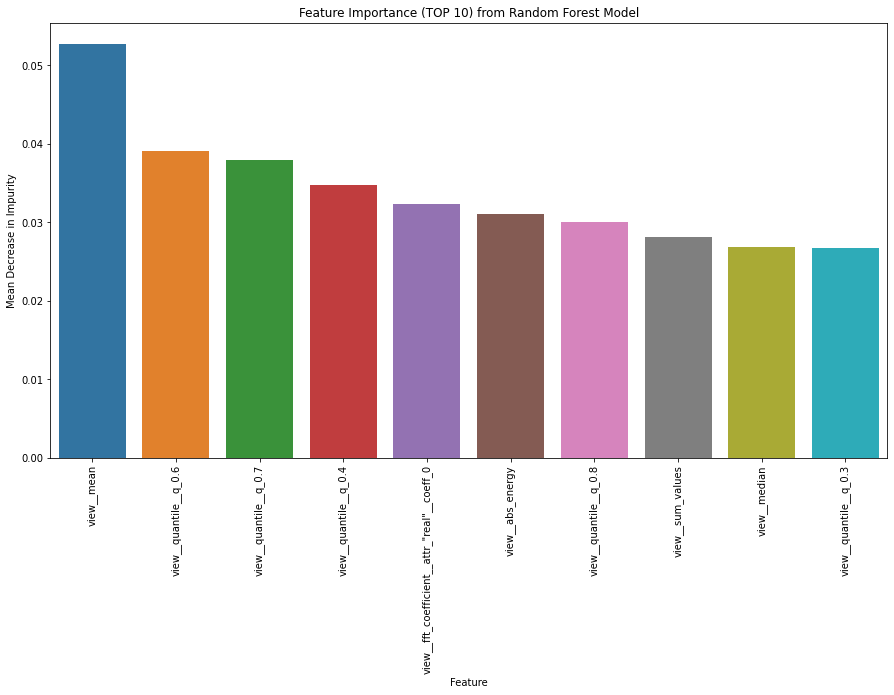

In [17]:
# plot feature importance plot for the best model
feature_df = pd.concat([pd.Series(X_filtered_train.columns), 
                        pd.DataFrame(model_best.feature_importances_)], axis=1)
feature_df.columns = ['Feature', 'Mean Decrease in Impurity']
feature_df.sort_values(by = ['Mean Decrease in Impurity'], inplace=True,ascending=False)
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
sns.barplot(x= 'Feature', y= 'Mean Decrease in Impurity', data=feature_df.iloc[:10])
plt.title("Feature Importance (TOP 10) from Random Forest Model")
plt.show()


Based on the TOP 10 Most Importatn Feature plot,  the view_mean and quantile-related features contribute the most to the predicted results. 

We can also plot the SHAP plot to see on average, whehter features contribute positively or negatively to the predicted results.

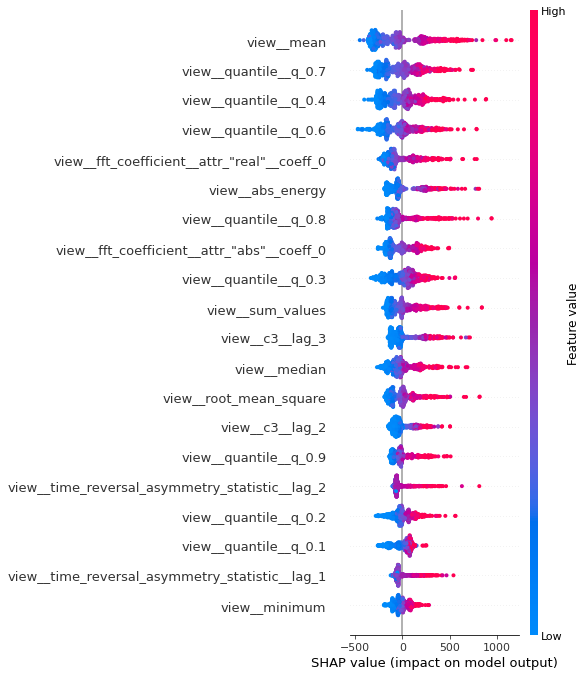

In [18]:
# plot SHAP dependence plots
explainer = shap.TreeExplainer(model_best) 

# shap plot for all observations - on average
shap_values = explainer(X_filtered_train)
shap.summary_plot(shap_values, feature_names=X_filtered_train.columns)
plt.show()

When zooming on one observation, here for example, the page "Anglicanism_en.wikipedia.org_all-access_all-agents", we are able to visualize the specific numerical contribution of every feature (here only TOP 10 are shown) to the predicted target, adding more interpretability in case the decision-maker is interested in one specfici page.

Page: Anglicanism_en.wikipedia.org_all-access_all-agents


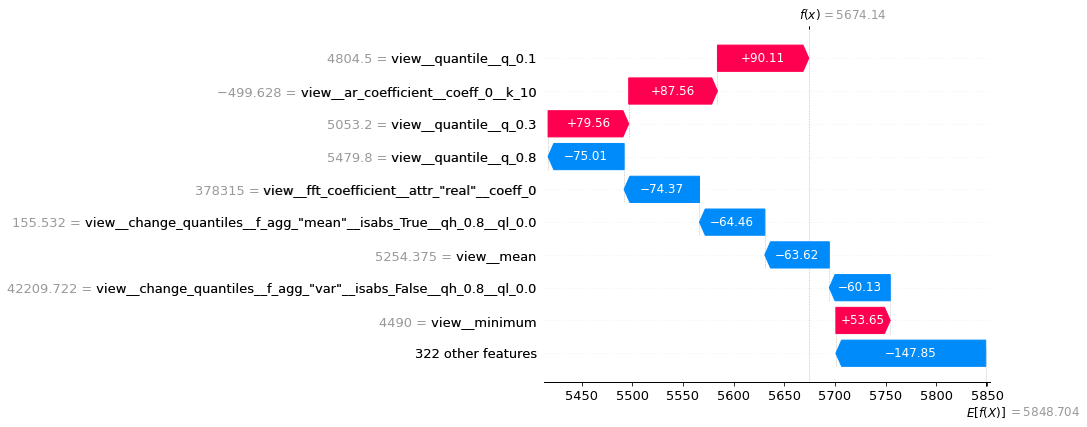

In [20]:
# shap plot for one observation
idx = 1
shap_object = shap.Explanation(base_values = shap_values[idx][0].base_values,
values = shap_values[idx].values,
feature_names = X_filtered_train.columns,
data = shap_values[idx].data)

print(f"Page: {df_sorted_std.iloc[idx]['Page']}")
shap.plots.waterfall(shap_object,max_display=10)

## 4. Further Test on Unseen Data ##

In [ ]:
%%time

## NOTE: this call can take up to 3+ hrs to run on Google Colab
## and it took me around 1+ hr to run locally
## I have stored the predicted results as 'code/ml_results.sav' in google drive
## Feel free to directly use it in the next cell if you want to save time

# exclude last date due to 104 missing value in raw target
lst = [i for i in range(536+72,len(df_sorted_std.columns)-1)] 
# creating sliding window with window size = 72 ~ 1.5 month
X_col,y_col = sliding_window(lst,72)

pred_dic = dict()
error_lst = []
r2_lst = []
true_dic = dict()

# predict through sliding windows
for (X,y) in zip(X_col, y_col):
    # impute feature dataframe
    df_imputed = df_sorted_std[df_sorted_std.columns[np.r_[0,X]]].interpolate(
        limit_direction='both')
    # reformat feature dataframe
    imputed_ts = (df_imputed.reset_index()
                              .rename(columns={'index':'page'})
                              .drop(columns='Page'))
    ts_X = (pd.melt(imputed_ts, 
                id_vars='page', 
                value_vars=list(imputed_ts.columns), 
                var_name='time', 
                value_name='view')
           .sort_values(by=['page','time'])
           .reset_index(drop=True))
    # get target series
    ts_y = df_sorted_std[df_sorted_std.columns[y]]
    # extract features
    f = extract_features(ts_X, column_id='page',column_sort="time")
    # impute and filter features
    X_filtered = impute(f)[filtered_features.columns]
    # predict and evaluate using the best model
    y_pred, error, r2 = predict_evaluate(X_filtered, ts_y, model_best)

    # store results
    pred_dic[ts_y.name] = y_pred
    error_lst.append(error)
    r2_lst.append(r2)
    true_dic[ts_y.name] = ts_y
    
       

Feature Extraction: 100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]


CPU times: user 2h 56min 27s, sys: 2min 21s, total: 2h 58min 49s
Wall time: 3h 3min


In [ ]:
# store results
results = pred_dic, error_lst, r2_lst, true_dic
pickle.dump(results, open('code/ml_results.sav', 'wb'))
#pred_dic, error_lst, r2_lst, true_dic = pickle.load(open('code/ml_results.sav', 'rb'))

In [ ]:
print(f'Average RMSE: {np.array(r2_lst).mean():.2f}')
print(f'Average R-squared: {np.array([np.sqrt(i) for i in error_lst]).mean():.2f}')

Average RMSE: 0.79
Average R-squared: 41.19


## 5. Prediction Results ##

In [ ]:
# format dataframe for true targets
df_true = pd.DataFrame([true_dic[i] for i in true_dic]).T
df_true.columns = [datetime.strptime(d,'%Y-%m-%d').date() for d in df_true.columns]

# format dataframe for predicted targets
df_pred = pd.DataFrame([pred_dic[i] for i in true_dic]).T
df_pred.columns = df_true.columns
df_pred.head()

,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,...,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09
0,1012.205,1009.885,968.070,961.490,1002.560,987.295,970.535,983.51,985.800,994.730,...,984.380,946.685,922.510,986.375,983.865,995.770,952.735,949.620,971.065,996.375
1,2230.725,2238.395,2189.585,2167.775,2196.675,2284.090,2217.220,2239.22,2171.925,2113.450,...,1815.065,1992.900,1944.330,1819.220,1843.695,1816.765,1986.245,2071.440,2417.535,2358.910
2,5288.870,5270.095,5204.015,5067.520,5112.150,5229.260,5249.615,5314.00,5211.220,5268.725,...,4765.720,4817.190,4709.845,4703.965,4774.065,4881.500,4794.940,4850.980,4825.400,4959.515
3,5346.425,5392.410,5349.590,5708.730,5632.235,5433.740,5514.010,5753.32,5681.905,5408.650,...,4583.030,4542.115,4551.555,4568.505,4552.160,4531.345,4668.200,4573.015,4520.875,4535.625
4,5616.255,5662.125,5837.825,5843.045,5910.335,5760.060,5707.415,5752.80,5743.005,6045.180,...,5412.360,5522.800,5349.815,5352.840,5425.255,5786.795,5590.250,5221.425,5490.050,5546.810


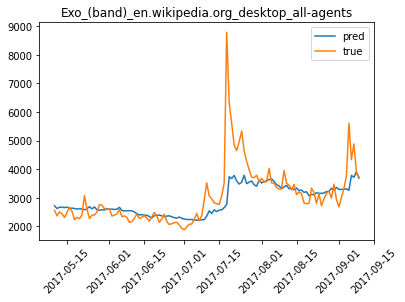

RMSE: 767.5326980106106
R-Squared: -1.3890874122647001




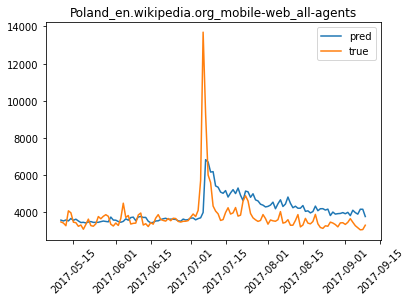

RMSE: 1141.6846978707545
R-Squared: -1.7860574203389863




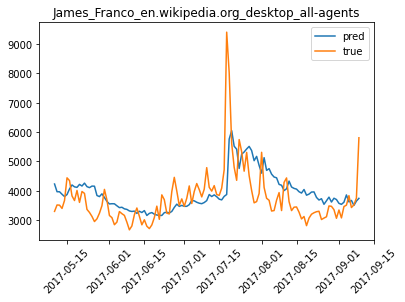

RMSE: 837.253719275617
R-Squared: -0.856677673417336




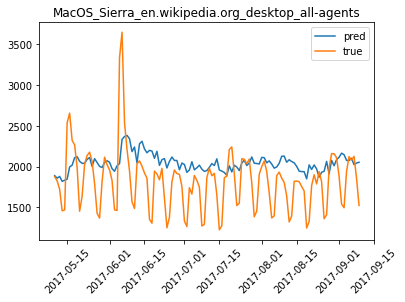

RMSE: 420.11254851759804
R-Squared: -14.93180763762148




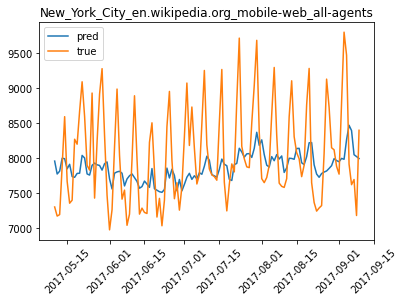

RMSE: 645.6758959963828
R-Squared: -10.503808223817169




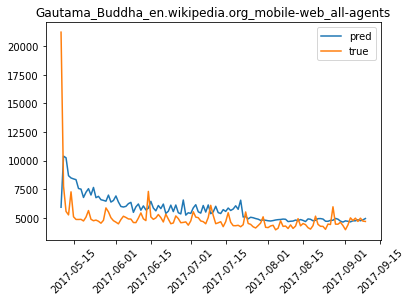

RMSE: 1903.7777196257164
R-Squared: -2.022268579733717




In [ ]:
# pick a few samples to observe predicted time trend
for i in [18,48,58,105,110,49]:
    plt.plot(df_pred.T[i], label = 'pred')
    plt.plot(df_true.T[i], label='true')
    plt.xticks(rotation=45)
    plt.title(f'{df_sorted_std.iloc[i,0]}')
    plt.legend()
    plt.show()
    print(f'RMSE: {np.sqrt(mean_squared_error(df_pred.T[i],df_true.T[i]))}')
    print(f'R-Squared: {r2_score(df_pred.T[i],df_true.T[i])}\n\n')

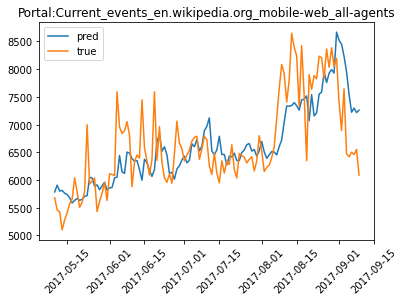

RMSE: 578.4079737721212
R-Squared: 0.2813169721499299




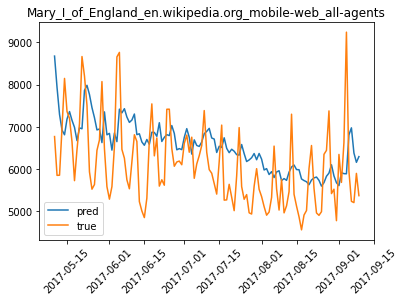

RMSE: 1012.7645501390206
R-Squared: -2.0190833706495313




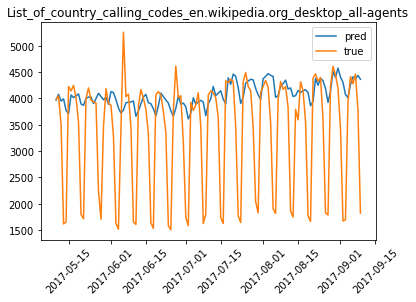

RMSE: 1256.0253181926125
R-Squared: -32.74030170245272




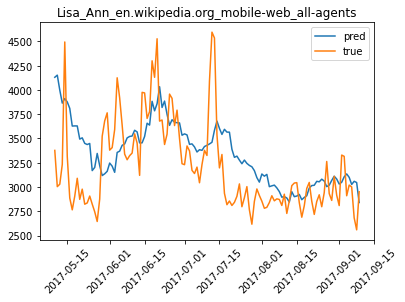

RMSE: 416.2461920827313
R-Squared: -0.7767472757527258




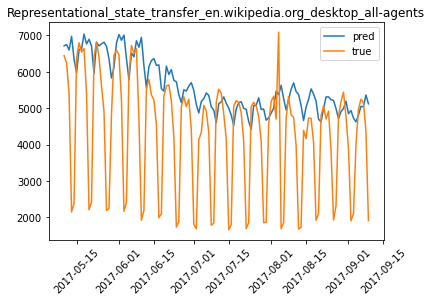

RMSE: 2056.944650827999
R-Squared: -7.066863977680134




In [ ]:
# pick out 5 examples to be compared with LSTM and Prophet results
web_lst = [
'Portal:Current_events_en.wikipedia.org_mobile-web_all-agents',
'Lisa_Ann_en.wikipedia.org_mobile-web_all-agents',
'Representational_state_transfer_en.wikipedia.org_desktop_all-agents',
'List_of_country_calling_codes_en.wikipedia.org_desktop_all-agents',
'Mary_I_of_England_en.wikipedia.org_mobile-web_all-agents']

for i in df_sorted_std[df_sorted_std['Page'].isin(web_lst)].index:
    plt.plot(df_pred.T[i], label = 'pred')
    plt.plot(df_true.T[i], label='true')
    plt.xticks(rotation=45)
    plt.title(f'{df_sorted_std.iloc[i,0]}')
    plt.legend()
    plt.show()
    print(f'RMSE: {np.sqrt(mean_squared_error(df_pred.T[i],df_true.T[i]))}')
    print(f'R-Squared: {r2_score(df_pred.T[i],df_true.T[i])}\n\n')

In [ ]:
# generate dataframe from the results above
df_compare = df_pred.iloc[np.r_[df_sorted_std[df_sorted_std['Page'].isin(web_lst)].index],:]
df_compare.insert(0, 'Page', df_sorted_std[df_sorted_std['Page'].isin(web_lst)]['Page'])
df_compare

,Page,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,...,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09
218,Portal:Current_events_en.wikipedia.org_mobile-...,5784.660,5907.925,5799.545,5813.745,5761.995,5739.895,5680.015,5585.835,5632.620,...,8666.870,8519.915,8449.290,8230.670,7951.490,7545.935,7222.620,7297.385,7217.485,7260.280
312,Mary_I_of_England_en.wikipedia.org_mobile-web_...,8673.625,7931.535,7292.215,6922.375,6810.810,7183.610,7360.655,7153.545,6986.930,...,5676.115,5607.735,5914.480,5891.000,5887.965,6809.045,6975.290,6380.850,6158.640,6294.030
323,List_of_country_calling_codes_en.wikipedia.org...,3966.785,4075.405,3948.340,3989.670,3770.445,3706.550,4062.550,4013.055,4047.010,...,4574.465,4403.495,4303.045,4071.870,4011.630,4264.985,4407.585,4364.585,4434.765,4361.680
354,Lisa_Ann_en.wikipedia.org_mobile-web_all-agents,4130.205,4152.430,3998.180,3864.245,3910.910,3876.025,3809.920,3627.820,3629.465,...,3082.245,3030.355,3049.175,3105.185,3134.715,3099.575,3026.195,3058.890,3046.145,2840.275
405,Representational_state_transfer_en.wikipedia.o...,6708.595,6746.465,6595.490,6970.850,6340.335,5969.235,6605.300,6620.665,7032.515,...,5188.485,4848.415,4932.645,4726.210,4623.315,4812.060,5048.550,5035.535,5361.305,5117.740


In [ ]:
# output to csv
df_compare.to_csv('data/ML_preds.csv',index=False)